In [43]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from typing import Type
from torch import nn
from torch.optim import optimizer
import rasterio
import zipfile
from matplotlib import pyplot as plt
import datetime
from torchvision import transforms as transforms
import shutil
import torchmetrics
import os
import pytorch_lightning as pl
import sklearn
from torch.nn import functional as F

# --- GPU selection --- #
gpus = 7 # slot number (e.g., 3), no gpu use -> write just ' '
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]=str(gpus)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
def minmax(array : Type[np.ndarray], dim = 0):
    min = np.min(array, axis=dim)
    max = np.max(array, axis=dim)
    array = (array-min)/(max-min)
    return array

def log_minmax(array : Type[np.ndarray], dim = 0):
    min = np.min(array, axis=dim)
    array = array - min + 1
    array = np.log(array)
    max = np.max(array, axis=dim)
    array = (array)/(max)
    return array

In [36]:
def save_result(model: Type[nn.Module], dataloader : Type[DataLoader], path:str, description:str = '', reference_data:str = '', patch_size:int = 60, now = datetime.datetime.now()):
    best_model = model
    os.makedirs(os.path.join(path,f'{now.year}.{now.month}.{now.day}/', f'{description}/','tmp/'), exist_ok=True)
    zipped_results = zipfile.ZipFile(os.path.join(path,f'{now.year}.{now.month}.{now.day}/',f'{description}/','RESULT_{0:0=2d}:{1:0=2d}'.format(now.hour, now.minute)+f'_{description}.zip'), 'w')
    prediction = np.zeros((60,60,7))
    for i, (data, index_OHE, index) in enumerate(dataloader):
        prediction[i, :, :] = best_model(data).detach().numpy()
    prediction_expanded = np.zeros((7,2400,2400))
    for i in range(60):
        for j in range(60):
            for k in range(7):
                prediction_expanded[k,i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = prediction[i,j,k]

    reference_image = rasterio.open(reference_data)
    layer_index = [1,2,7,8,9,10,11]

    for i in range(prediction_expanded.shape[0]):
        print('a') 
        processed_tiff = rasterio.open(
            os.path.join(path,f'{now.year}.{now.month}.{now.day}/',f'{description}/', 'tmp/', f'Result_{layer_index[i]}_{description}.tif'),
            'w',
            driver='GTiff',
            height=prediction_expanded.shape[1],
            width=prediction_expanded.shape[2],
            count=1,
            dtype=prediction_expanded.dtype,
            crs=reference_image.crs,
            transform=reference_image.transform,
        )
        print('b')
        processed_tiff.write(prediction_expanded[i,:,:],1)
        processed_tiff.close()
        print('c')
        zipped_results.write(os.path.join(path,f'{now.year}.{now.month}.{now.day}/',f'{description}/', 'tmp/', f'Result_{layer_index[i]}_{description}.tif'), f'Result_{layer_index[i]}_{description}.tif')

    zipped_results.close()
    return os.path.join(path,f'{now.year}.{now.month}.{now.day}/',f'{description}/','RESULT_{0:0=2d}:{1:0=2d}'.format(now.hour, now.minute)+f'_{description}.zip')


In [39]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, device, num_epochs=13, train_rate: float = 0.8, batch_size: int = 60, path:str = '../Data/N12/Model/', description:str = 'no_description', reference_data:str = ''): 
    train_loss_history = []
    valid_loss_history = []

    patch_size = dataloaders['Train'].dataset.data.shape[-1]
    training_patches = len(dataloaders['Train'].dataset)
    validating_patches = len(dataloaders['Validation'].dataset)
    print(f'Training Patches : {training_patches}\nValidating Patches : {validating_patches}')

    best_model_epoch = 0
    least_valid_loss = 100
    now = datetime.datetime.now()
    os.makedirs(os.path.join(path,f'{now.year}.{now.month}.{now.day}/',f'{description}/', 'tmp/'), exist_ok=True)
    zipped_model = zipfile.ZipFile(os.path.join(path,f'{now.year}.{now.month}.{now.day}/',f'{description}/', '{0:0=2d}:{1:0=2d}'.format(now.hour, now.minute)+f'_{description}'+'.zip'), 'w')
    
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        train_running_loss = 0.0
        valid_running_loss = 0.0

        for state in ['Train', 'Validation']:
            for i, (inputs, labels_OHE, labels) in enumerate(dataloaders[state]):
                
                inputs = inputs.to(device)
                labels = labels.to(device)
                model.to(device)
                
                outputs = model(inputs)
                
                optimizer.zero_grad()

                if state == 'Train':
                    model.train()
                    train_loss = criterion(outputs, labels)
                    train_loss.backward()
                    train_running_loss += train_loss.item() * inputs.size(0)
                
                if state == 'Validation':
                    model.eval()
                    valid_loss = criterion(outputs, labels)
                    valid_running_loss += valid_loss.item() * inputs.size(0)

                optimizer.step()
                #valid_running_similarity += metric(outputs, labels)
                #print('validating')
                
                #print(f'{i}th batch')
            


        
        #print(f'Memory after a training : {torch.cuda.memory_allocated()/1024/1024}')

        epoch_train_loss = train_running_loss / training_patches
        epoch_valid_loss = valid_running_loss / validating_patches
        scheduler.step(epoch_valid_loss)

        print(f'Valid loss: {epoch_valid_loss} | Train loss: {epoch_train_loss}')


        if epoch_valid_loss < least_valid_loss:
            least_valid_loss = epoch_valid_loss
            best_model_epoch = epoch

        train_loss_history.append(epoch_train_loss)      
        valid_loss_history.append(epoch_valid_loss)

        torch.save(model.state_dict(), os.path.join(path,f'{now.year}.{now.month}.{now.day}/',f'{description}/','tmp/', '{0:0=2d}.pth'.format(epoch)))
        zipped_model.write(os.path.join(path,f'{now.year}.{now.month}.{now.day}/',f'{description}/','tmp/', '{0:0=2d}.pth'.format(epoch)))

    plt.figure(figsize=(20,8))
    plt.plot(train_loss_history, 'r-')
    plt.plot(valid_loss_history, 'bo')
    plt.savefig(os.path.join(path,f'{now.year}.{now.month}.{now.day}/',f'{description}/','tmp/', 'Tendency.png'), dpi=300)
    zipped_model.write(os.path.join(path,f'{now.year}.{now.month}.{now.day}/',f'{description}/','tmp/', 'Tendency.png'))
    zipped_model.writestr('README.txt', f'{description}\nThe best Model : #{best_model_epoch}th model with loss {least_valid_loss}\nOptimizer : {optimizer}\nLoss function : {criterion}\nBatch size : {batch_size}\nScheduler : {scheduler}\nPatch size : {patch_size}\nTotal epochs : {num_epochs}\nModel information :\n{model.modules}')
    
    print('Best loss: {:4f}, in Epoch #{:0=3d}'.format(least_valid_loss, best_model_epoch))    
    zipped_model.close()
    shutil.copy(src=os.path.join(path,f'{now.year}.{now.month}.{now.day}/',f'{description}/', 'tmp/', '{0:0=2d}.pth'.format(epoch)), dst=os.path.join(path,f'{now.year}.{now.month}.{now.day}/', 'Best_Model_Parameters_of_{0:0=2d}:{1:0=2d}'.format(now.hour, now.minute)+f'_{description}'+'.pth'))
    print('Model information is saved in '+os.path.join(path,f'{now.year}.{now.month}.{now.day}/',f'{description}/', '{0:0=2d}:{1:0=2d}'.format(now.hour, now.minute)+f'_{description}'+'.zip'))

    '''model.load_state_dict(torch.load(os.path.join(path,f'{now.year}.{now.month}.{now.day}/',f'{description}/','tmp/', '{0:0=2d}.pth'.format(best_model_epoch))))
    result_path = save_result(model = model.to('cpu'), dataloader=dataloaders['Prediction'], path=path, description=description, reference_data=reference_data, patch_size=patch_size, now=now)
    print('Model result is saved in '+ result_path)'''
    
    shutil.rmtree(os.path.join(path,f'{now.year}.{now.month}.{now.day}/',f'{description}/','tmp/'))
    best_model_path = os.path.join(path,f'{now.year}.{now.month}.{now.day}/', 'Best_Model_Parameters_of_{0:0=2d}:{1:0=2d}'.format(now.hour, now.minute)+f'_{description}'+'.pth')
    return best_model_path

In [16]:
def prepare_raw_files():
    '''if os.path.exists('../Data/N12/np/train_array.npy') and os.path.exists('../Data/N12/np/target_array_OHE.npy'):
        train_array = np.load('../Data/N12/np/train_array.npy')
        target_array = np.load('../Data/N12/np/target_array_OHE.npy')
    else:'''
    lidar_image = rasterio.open('../Data/N12/N12_lidar.tif').read()
    lidar_array = np.array(lidar_image)
    lidar_array = log_minmax(lidar_array, dim=(0,1))

    lidar_1n_image = rasterio.open('../Data/N12/N12_lidar_1n.tif').read()
    lidar_1n_array = np.array(lidar_1n_image)
    lidar_1n_array = log_minmax(lidar_1n_array, dim=(0,1))

    lidar_nt_image = rasterio.open('../Data/N12/N12_lidar_nt.tif').read()
    lidar_nt_array = np.array(lidar_nt_image)
    lidar_nt_array = log_minmax(lidar_nt_array, dim=(0,1))

    RGB2020_image = rasterio.open('../Data/N12/N12_RGB2020.tif').read()
    RGB2020_array = np.array(RGB2020_image)

    train_array = np.stack([lidar_array, lidar_1n_array, lidar_nt_array]).squeeze()
    train_array = np.concatenate((train_array,RGB2020_array))
    target_image = rasterio.open('../Data/N12/N12_newlc.tif').read()
    target_array = np.array(target_image, dtype=int).squeeze()
    target_array = np.where(target_array == 1, 0, target_array)
    target_array = np.where(target_array == 2, 1, target_array)
    target_array = np.where(target_array == 7, 2, target_array)
    target_array = np.where(target_array == 8, 3, target_array)
    target_array = np.where(target_array == 9, 4, target_array)
    target_array = np.where(target_array == 10, 5, target_array)
    target_array = np.where(target_array == 11, 6, target_array)

    target_array_OHE = np.zeros(shape=(7,2400,2400))
    num = np.unique(target_array)
    num = num.shape[0]
    encoded_target_array = np.eye(num)[target_array]
    for i in range(encoded_target_array.shape[-1]):
        target_array_OHE[i,:,:]=encoded_target_array[:,:,i]

    return train_array, target_array.astype(int), target_array_OHE.astype(int)

In [22]:
class TrainDataset2(Dataset):
    def __init__(self, data_array : Type[np.ndarray], target_array_OHE : Type[np.ndarray], target_array_RAW : Type[np.ndarray], patch_size : int, is_evaluating : bool = False, is_validating : bool = False, rotate : bool = False, train_ratio : float = 0.8):
        self.is_validating = is_validating
        self.is_evaluating = is_evaluating
        seed = 386579

        #print(f'Data shape: {data_array.shape} | Target shape: {target_array.shape}')

        self.data = np.zeros(((data_array.shape[1]//patch_size) * (data_array.shape[2]//patch_size), data_array.shape[0], patch_size, patch_size))

        for i in range(0,data_array.shape[1]//patch_size):
            for j in range(0,data_array.shape[2]//patch_size):
                self.data[data_array.shape[1]//patch_size*i+j,:,:,:] = data_array[:,i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]

        self.label_OHE = np.zeros(((data_array.shape[1]//patch_size) * (data_array.shape[2]//patch_size), target_array_OHE.shape[0] ,patch_size, patch_size), dtype=float)
        for k in range(0,data_array.shape[1]//patch_size):
            for l in range(0,data_array.shape[2]//patch_size):
                self.label_OHE[data_array.shape[1]//patch_size*k+l,:,:,:] = target_array_OHE[:,i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]

        self.label_RAW = np.zeros(((data_array.shape[1]//patch_size) * (data_array.shape[2]//patch_size),data_array.shape[0]+1))
        for k in range(0,data_array.shape[1]//patch_size):
            for l in range(0,data_array.shape[2]//patch_size):
                self.label_RAW[data_array.shape[1]//patch_size*k+l,:] = np.bincount(target_array_RAW[k*patch_size:(k+1)*patch_size, l*patch_size:(l+1)*patch_size].reshape(-1), minlength=7)/(patch_size*patch_size)


        if not is_evaluating:
            if rotate:
                for i in range(2):
                    rotated_data = np.rot90(self.data, k=i+1, axes=(-2, -1))
                    self.data = np.concatenate((self.data, rotated_data), axis=0)
                    rotated_label_OHE = np.rot90(self.label_OHE, k=i+1, axes=(-2, -1))
                    rotated_label_RAW = self.label_RAW
                    self.label_OHE = np.concatenate((self.label_OHE, rotated_label_OHE), axis=0)
                    self.label_RAW = np.concatenate((self.label_RAW, rotated_label_RAW), axis=0)

        train_size = int(self.data.shape[0]*train_ratio)
        index_array = np.random.RandomState(seed=seed).permutation(self.data.shape[0])
        self.train_index = index_array[0:train_size]
        self.valid_index = index_array[train_size:index_array.shape[0]]
        
        self.data = torch.as_tensor(self.data).float()
        self.label_OHE = torch.as_tensor(self.label_OHE).float()
        self.label_RAW = torch.as_tensor(self.label_RAW).float()

        self.data[:,3:6,:,:] = self.data[:,3:6,:,:]/255

    def __len__(self):
        if self.is_evaluating:
            return self.data.shape[0]

        if self.is_validating:
            return self.valid_index.shape[0]
        else:
            return self.train_index.shape[0]

    def __getitem__(self, idx):
        if self.is_evaluating:
            sample = torch.as_tensor(self.data[idx,:,:,:]).float()
            label_OHE = torch.as_tensor(self.label_OHE[idx,:]).float()
            label_RAW = torch.as_tensor(self.label_RAW[idx,:]).float()
            return sample, label_OHE, label_RAW
        
        if self.is_validating:
            sample = torch.as_tensor(self.data[self.valid_index[idx],:,:,:]).float()
            label_OHE = torch.as_tensor(self.label_OHE[self.valid_index[idx],:]).float()
            label_RAW = torch.as_tensor(self.label_RAW[self.valid_index[idx],:]).float()
        else:
            sample = torch.as_tensor(self.data[self.train_index[idx],:,:,:]).float()
            label_OHE = torch.as_tensor(self.label_OHE[self.train_index[idx],:]).float()
            label_RAW = torch.as_tensor(self.label_RAW[self.train_index[idx],:]).float()

        return sample, label_OHE, label_RAW

In [8]:
def fixed_padding(inputs, kernel_size, dilation):
    kernel_size_effective = kernel_size + (kernel_size - 1) * (dilation - 1)
    pad_total = kernel_size_effective - 1
    pad_beg = pad_total // 2
    pad_end = pad_total - pad_beg
    padded_inputs = F.pad(inputs, (pad_beg, pad_end, pad_beg, pad_end))
    return padded_inputs


class SeparableConv2d(nn.Module):
    def __init__(self, inplanes, planes, kernel_size=3, stride=1, dilation=1, bias=False, BatchNorm=None):
        super(SeparableConv2d, self).__init__()

        self.conv1 = nn.Conv2d(inplanes, inplanes, kernel_size, stride, 0, dilation,
                               groups=inplanes, bias=bias)
        self.bn = BatchNorm(inplanes)
        self.pointwise = nn.Conv2d(inplanes, planes, 1, 1, 0, 1, 1, bias=bias)

    def forward(self, x):
        x = fixed_padding(x, self.conv1.kernel_size[0], dilation=self.conv1.dilation[0])
        x = self.conv1(x)
        x = self.bn(x)
        x = self.pointwise(x)
        return x

In [64]:
class ConvBN(nn.Module):
    def __init__(self, C_in, C_out, kernel_size, stride, dilation = 1, affine=True, fix_padding = False):
        super(ConvBN, self).__init__()
        self.fix_padding = fix_padding
        self.conv2d = nn.Conv2d(C_in, C_in, kernel_size=kernel_size, stride=stride, groups=C_in, bias=False, dilation=dilation)
        self.pointwise = nn.Conv2d(C_in, C_out, kernel_size=1, padding=0, bias=False)
        self.batchnorm = nn.BatchNorm2d(C_in, affine=affine)
        

    def forward(self, x):
        if self.fix_padding:
           x = fixed_padding(x, self.conv2d.kernel_size[0], dilation=self.conv2d.dilation[0])
        x = self.conv2d(x)
        x = self.batchnorm(x)
        x = self.pointwise(x)
        return x

In [10]:
'''class Block(nn.Module):
    def __init__(self, C_in, C_out, reps, stride = 1, dilation = 1, grow_first = True, start_with_relu = True, is_last = False):
        super(Block, self).__init__()
        
        if C_in!=C_out or stride!=1:
            self.skip = ConvBN(C_in, C_out, kernel_size=1, stride=stride)
        else:
            self.skip = None

        self.relu = nn.ReLU(inplace=True)
        rep = []

        filters = C_in
        if grow_first:
            rep.append(self.relu)
            rep.append(ConvBN(C_in, C_out, kernel_size=3, stride=1, dilation = dilation))
            filters = C_out

        for i in range(reps-1):
            rep.append(self.relu)
            rep.append(ConvBN(filters, filters, 3, stride=1, dilation = dilation))

        if not grow_first:
            rep.append(self.relu)
            rep.append(ConvBN(C_in, C_out, 3, stride=1, dilation = dilation))

        if stride != 1:
            rep.append(self.relu)
            rep.append(ConvBN(C_out, C_out, 3, stride=2, dilation = dilation))

        if stride == 1 and is_last:
            rep.append(self.relu)
            rep.append(ConvBN(C_out, C_out, 3, 1))

        if not start_with_relu:
            rep = rep[1:]

        self.rep = nn.Sequential(*rep)

    def forward(self, x):
        #print(f'Shape before residual : {x.shape}')

        if self.skip is not None:
            #print('trying residual')
            skip = self.skip(x)
            #print('succeded residual')
        else:
            skip = x
        x = self.rep(x)

        #print(f'Shape after residual : {x.shape}')
        x += skip
        return x

    

        '''

"class Block(nn.Module):\n    def __init__(self, C_in, C_out, reps, stride = 1, dilation = 1, grow_first = True, start_with_relu = True, is_last = False):\n        super(Block, self).__init__()\n        \n        if C_in!=C_out or stride!=1:\n            self.skip = ConvBN(C_in, C_out, kernel_size=1, stride=stride)\n        else:\n            self.skip = None\n\n        self.relu = nn.ReLU(inplace=True)\n        rep = []\n\n        filters = C_in\n        if grow_first:\n            rep.append(self.relu)\n            rep.append(ConvBN(C_in, C_out, kernel_size=3, stride=1, dilation = dilation))\n            filters = C_out\n\n        for i in range(reps-1):\n            rep.append(self.relu)\n            rep.append(ConvBN(filters, filters, 3, stride=1, dilation = dilation))\n\n        if not grow_first:\n            rep.append(self.relu)\n            rep.append(ConvBN(C_in, C_out, 3, stride=1, dilation = dilation))\n\n        if stride != 1:\n            rep.append(self.relu)\n         

In [11]:
'''class Xception(nn.Module):
    def __init__(self, output_stride=16):
        super(Xception, self).__init__()
        if output_stride == 16:
            entry_block3_stride = 2
            middle_block_dilation = 1
            exit_block_dilations = (1, 2)
        elif output_stride == 8:
            entry_block3_stride = 1
            middle_block_dilation = 2
            exit_block_dilations = (2, 4)
        else:
            raise NotImplementedError

        self.entry_flow = nn.Sequential(
            nn.Conv2d(6, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            Block(64, 128, reps=2, stride=2, start_with_relu=False),
            Block(128, 256, reps=2, stride=2, start_with_relu=False, grow_first=True),
            Block(256, 728, reps=2, stride=entry_block3_stride, start_with_relu=True, grow_first=True, is_last=True)
        )

        self.middle_flow = nn.Sequential(
            Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation, start_with_relu=True, grow_first=True),
            Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation, start_with_relu=True, grow_first=True),
            Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation, start_with_relu=True, grow_first=True),
            Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation, start_with_relu=True, grow_first=True),
            Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation, start_with_relu=True, grow_first=True),
            Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation, start_with_relu=True, grow_first=True),
            Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation, start_with_relu=True, grow_first=True),
            Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation, start_with_relu=True, grow_first=True)
        )

        self.exit_flow = nn.Sequential(
            Block(728, 1024, reps=2, stride=1, dilation=exit_block_dilations[0], start_with_relu=True, grow_first=False, is_last=True),
            ConvBN(1024, 1536, 3, stride=1, dilation=exit_block_dilations[1]),
            ConvBN(1536, 1536, 3, stride=1, dilation=exit_block_dilations[1]),
            ConvBN(1536, 2048, 3, stride=1, dilation=exit_block_dilations[1])
        )

    def forward(self, x):
        x = self.entry_flow(x)
        x = self.middle_flow(x)
        x = self.exit_flow(x)
        return x'''

'class Xception(nn.Module):\n    def __init__(self, output_stride=16):\n        super(Xception, self).__init__()\n        if output_stride == 16:\n            entry_block3_stride = 2\n            middle_block_dilation = 1\n            exit_block_dilations = (1, 2)\n        elif output_stride == 8:\n            entry_block3_stride = 1\n            middle_block_dilation = 2\n            exit_block_dilations = (2, 4)\n        else:\n            raise NotImplementedError\n\n        self.entry_flow = nn.Sequential(\n            nn.Conv2d(6, 32, kernel_size=3, stride=2, padding=1, bias=False),\n            nn.BatchNorm2d(32),\n            nn.ReLU(),\n            nn.Conv2d(32,64, kernel_size=3, stride=1, padding=1, bias=False),\n            nn.BatchNorm2d(64),\n            nn.ReLU(),\n            Block(64, 128, reps=2, stride=2, start_with_relu=False),\n            Block(128, 256, reps=2, stride=2, start_with_relu=False, grow_first=True),\n            Block(256, 728, reps=2, stride=entry_bloc

In [41]:
class UrbanGreenRegression(nn.Module):
    def __init__(self):
        super(UrbanGreenRegression, self).__init__()
        self.conv_block_1 = nn.Sequential(
            ConvBN(6,32,3,1),#48
            nn.ReLU(),
            ConvBN(32,32,3,1),#46
            nn.ReLU(),
            ConvBN(32,32,3,1),#44
            nn.ReLU(),
            nn.MaxPool2d(2)#22
        )
        self.conv_block_2 = nn.Sequential(
            ConvBN(32,64,3,1),#20
            nn.ReLU(),
            ConvBN(64,64,3,1),#18
            nn.ReLU(),
            ConvBN(64,64,3,1),#16
            nn.ReLU(),
            nn.MaxPool2d(2)#8
        )

        self.fc_block_1 = nn.Sequential(
            nn.Linear(in_features=4096, out_features=1024, bias=False),
            nn.BatchNorm1d(num_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=1024, bias=False),
            nn.BatchNorm1d(num_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=1024, bias=False),
            nn.BatchNorm1d(num_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=1024, bias=False),
            nn.BatchNorm1d(num_features=1024),
            nn.ReLU()
        )

        self.fc_block_2 = nn.Sequential(
            nn.Linear(in_features=1024, out_features=256, bias=False),
            nn.BatchNorm1d(num_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=64, bias=False),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64,7, False),
            nn.BatchNorm1d(7)
        )

    def forward(self,x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        #print(x.shape)
        x = x.view(x.shape[0], -1)
        #print(x.shape)
        x = self.fc_block_1(x)
        x = self.fc_block_2(x)
        return torch.softmax(x, dim=-1)

In [23]:
raw_data_array ,raw_target_array, OHE_target_array = prepare_raw_files()
batch_size = 64
patch_size = 50
train_ratio = 0.8
rotate_training_data = True
Datasets_NON_OHE = {
    'Train' : TrainDataset2(raw_data_array, OHE_target_array, raw_target_array, patch_size = patch_size, rotate = rotate_training_data, train_ratio = train_ratio),
    'Validation' : TrainDataset2(raw_data_array, OHE_target_array, raw_target_array, patch_size = patch_size, is_validating = True, rotate = rotate_training_data, train_ratio = train_ratio),
    'Prediction' : TrainDataset2(raw_data_array, OHE_target_array, raw_target_array, patch_size = patch_size, is_evaluating = True, train_ratio = train_ratio)
}

In [24]:
Dataloaders_NON_OHE = {
    'Train' : DataLoader(Datasets_NON_OHE['Train'], batch_size=64),
    'Validation' : DataLoader(Datasets_NON_OHE['Validation'], batch_size=64),
    'Prediction' : DataLoader(Datasets_NON_OHE['Prediction'], batch_size=64)
}

In [32]:
from torchsummary import summary
model_for_summary = UrbanGreenRegression()
model_for_summary.to(device)
summary(model_for_summary, input_size=(6,50,50), batch_size=64)

torch.Size([2, 64, 8, 8])
torch.Size([2, 4096])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [64, 6, 48, 48]              54
       BatchNorm2d-2            [64, 6, 48, 48]              12
            Conv2d-3           [64, 32, 48, 48]             192
            ConvBN-4           [64, 32, 48, 48]               0
              ReLU-5           [64, 32, 48, 48]               0
            Conv2d-6           [64, 32, 46, 46]             288
       BatchNorm2d-7           [64, 32, 46, 46]              64
            Conv2d-8           [64, 32, 46, 46]           1,024
            ConvBN-9           [64, 32, 46, 46]               0
             ReLU-10           [64, 32, 46, 46]               0
           Conv2d-11           [64, 32, 44, 44]             288
      BatchNorm2d-12           [64, 32, 44, 44]              64
           Conv2d-13           [64, 32, 44, 44]        

Training Patches : 7372
Validating Patches : 1844
Epoch 0/99
----------
Valid loss: 0.033291645024836454 | Train loss: 0.05425461253926473
Epoch 1/99
----------
Valid loss: 0.029653328747656235 | Train loss: 0.029041698509731245
Epoch 2/99
----------
Valid loss: 0.028639159393607925 | Train loss: 0.020652578709565196
Epoch 3/99
----------
Valid loss: 0.025827271314317647 | Train loss: 0.016121469875691512
Epoch 4/99
----------
Valid loss: 0.02258899927527165 | Train loss: 0.013687958245024659
Epoch 5/99
----------
Valid loss: 0.022210540140851717 | Train loss: 0.011740701006269623
Epoch 6/99
----------
Valid loss: 0.021860769067016186 | Train loss: 0.009965909934515255
Epoch 7/99
----------
Valid loss: 0.02147361095550262 | Train loss: 0.008390276861082454
Epoch 8/99
----------
Valid loss: 0.022062075362740782 | Train loss: 0.007229629284497583
Epoch 9/99
----------
Valid loss: 0.021832878125625423 | Train loss: 0.00660079700050636
Epoch 10/99
----------
Valid loss: 0.02218183122753062

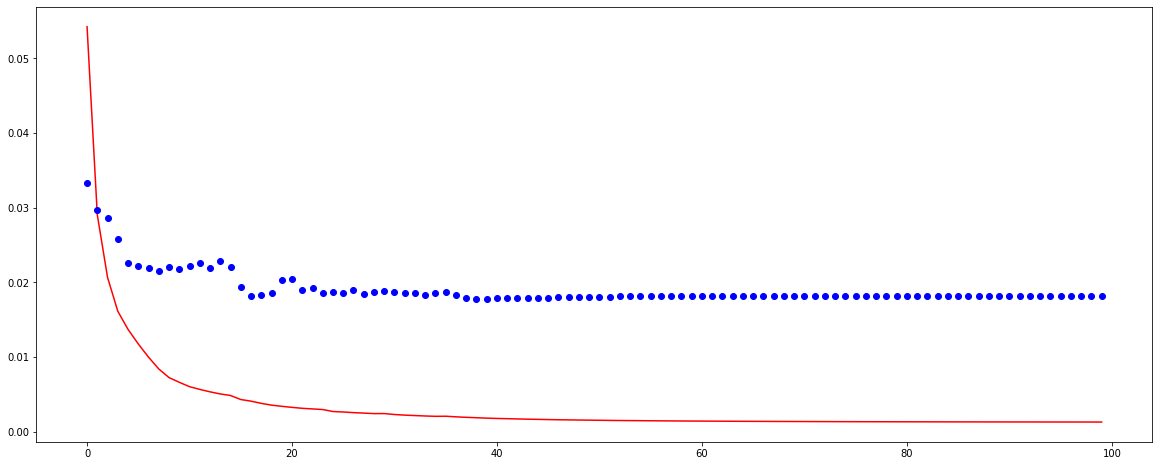

In [42]:
model2 = UrbanGreenRegression()
criterion2 = torch.nn.MSELoss(reduction='mean')
optimizer2 = torch.optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)
scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer2, 'min', patience=5, factor=0.75)
best_model_path = train_model(model2, Dataloaders_NON_OHE, criterion2, optimizer2, scheduler2, device, num_epochs=100, batch_size=batch_size, path='/home/bcyoon/Byeongchan/Data/N12/Model/Segmentation/Regression/', description='patch_50')

In [97]:
class ConvBN(nn.Module):
    def __init__(self, Cin, Cout, kernel_size, stride=1):
        super(ConvBN,self).__init__()
        self.conv = nn.Conv2d(Cin, Cin, kernel_size=kernel_size, stride=stride, groups=Cin, bias=False)
        self.batchnorm = nn.BatchNorm2d(Cin)
        self.pointwise = nn.Conv2d(Cin, Cout, kernel_size=1, padding=0, bias=False)
    def forward(self,x):
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.pointwise(x)
        return x

In [98]:
model_for_summary = SegBlock(skip=True, in_channel=64, out_channel=128)
model_for_summary.to(device)
summary(model_for_summary, input_size=(64,140,140), batch_size=16)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [16, 64, 138, 138]             576
       BatchNorm2d-2         [16, 64, 138, 138]             128
            Conv2d-3        [16, 128, 138, 138]           8,192
            ConvBN-4        [16, 128, 138, 138]               0
              ReLU-5        [16, 128, 138, 138]               0
            Conv2d-6        [16, 128, 136, 136]           1,152
       BatchNorm2d-7        [16, 128, 136, 136]             256
            Conv2d-8        [16, 128, 136, 136]          16,384
            ConvBN-9        [16, 128, 136, 136]               0
             ReLU-10        [16, 128, 136, 136]               0
Total params: 26,688
Trainable params: 26,688
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 76.56
Forward/backward pass size (MB): 2635.25
Params size (MB): 0.10
Estimated

In [100]:
def crop_add(skip:Type[torch.Tensor], target:Type[torch.Tensor])->torch.Tensor:
    cropped_skip = skip[:,:,(skip.shape[-2]-target.shape[-2])//2:(skip.shape[-2]+target.shape[-2])//2,(skip.shape[-1]-target.shape[-1])//2:(skip.shape[-1]+target.shape[-1])//2]
    return torch.cat((cropped_skip, target), dim=1)

### U-Net 마지막에 Fully Convolutional Layer 추가하기

In [101]:
class SegBlock(nn.Module):
    def __init__(self, skip:bool, in_channel:int, out_channel:int, is_last:bool = False):
        super(SegBlock,self).__init__()
        self.skip = skip
        self.is_last = is_last
        self.conv1 = ConvBN(in_channel, out_channel, kernel_size=3, stride=1)
        self.relu1 = nn.ReLU()
        self.conv2 = ConvBN(out_channel, out_channel, kernel_size=3, stride=1)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        return x

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.enc1 = SegBlock(True, 3,64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = SegBlock(True, 64,128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = SegBlock(True, 128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = SegBlock(True, 256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.dec0 = SegBlock(False, 512, 1024)
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec1 = SegBlock(False,1024,512)
        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec2 = SegBlock(False,512,256)
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec3 = SegBlock(False,256,128)
        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec4 = SegBlock(False,128,64, is_last = True)

    def forward(self,x):
        enc1 = self.enc1(x)
        x = self.pool1(enc1)
        enc2 = self.enc2(x)
        x = self.pool2(enc2)
        enc3 = self.enc3(x)
        x = self.pool3(enc3)
        enc4 = self.enc4(x)
        x = self.pool4(enc4)
        x = self.dec0(x)
        x = self.upconv1(x)
        x = self.dec1(crop_add(enc4, x))
        x = self.upconv2(x)
        x = self.dec2(crop_add(enc3, x))
        x = self.upconv3(x)
        x = self.dec3(crop_add(enc2, x))
        x = self.upconv4(x)
        x = self.dec4(crop_add(enc1, x))
        return x


In [102]:
model_for_summary = UNet()
model_for_summary.to(device)
summary(model_for_summary, input_size=(3,284,284), batch_size=8)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [8, 3, 282, 282]              27
       BatchNorm2d-2           [8, 3, 282, 282]               6
            Conv2d-3          [8, 64, 282, 282]             192
            ConvBN-4          [8, 64, 282, 282]               0
              ReLU-5          [8, 64, 282, 282]               0
            Conv2d-6          [8, 64, 280, 280]             576
       BatchNorm2d-7          [8, 64, 280, 280]             128
            Conv2d-8          [8, 64, 280, 280]           4,096
            ConvBN-9          [8, 64, 280, 280]               0
             ReLU-10          [8, 64, 280, 280]               0
         SegBlock-11          [8, 64, 280, 280]               0
        MaxPool2d-12          [8, 64, 140, 140]               0
           Conv2d-13          [8, 64, 138, 138]             576
      BatchNorm2d-14          [8, 64, 1

In [ ]:
class UrbanGreenSegmentation(pl.LightningModule):
    def __init__(self, rotate_training_data : bool = False, train_ratio : float = 0.8, patch_size : int = 100, batch_size : int = 16):
        super(UrbanGreenSegmentation, self).__init__()
        raw_data_array, OHE_target_array, raw_target_array = prepare_raw_files()
        self.batch_size = batch_size

        self.Datasets = {
            'Train' : TrainDataset2(raw_data_array, OHE_target_array, raw_target_array, patch_size = patch_size, rotate = rotate_training_data, train_ratio = train_ratio),
            'Validation' : TrainDataset2(raw_data_array, OHE_target_array, raw_target_array, patch_size = patch_size, is_validating = True, rotate = rotate_training_data, train_ratio = train_ratio),
            'Prediction' : TrainDataset2(raw_data_array, OHE_target_array, raw_target_array, patch_size = patch_size, is_evaluating = True, train_ratio = train_ratio)
        }
        
        self.Dataloaders = {
            'Train' : DataLoader(self.Datasets['Train'], batch_size=batch_size),
            'Validation' : DataLoader(self.Datasets['Validation'], batch_size=batch_size),
            'Prediction' : DataLoader(self.Datasets['Prediction'], batch_size=batch_size)
        }
        

        


        pass

    def forward(self, x):
        pass

    def training_step(self, batch, batch_idx):
        pass

    def validation_step(self, batch, batch_idx):
        pass

    def predict_step(self, batch, batch_idx):
        pass

    def configure_optimizers(self):
        train_optimizer = torch.optim.Adam(self.parameters(), lr=0.02)
        train_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(train_optimizer, T_max=10)
        return [train_optimizer], [train_scheduler]

    def train_dataloader(self):
        return DataLoader(self.Datasets['Train'], batch_size = self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.Datasets['Validation'], batch_size = self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.Datasets['Prediction'], batch_size = self.batch_size)